# App for analyzing GECCO runs from the Galaxy

1. Upload local data or query results of the GECCO from the Galaxy.
2. Identifying Biosynthetic Gene Clusters (BGCs).
3. Visualize BGCs.
4. Compare two samples in respect to each other.

Note: Sending GECCO jobs to Galaxy is part of another separate application.

## Platform dependent part
- Resolve platform setup
- the difference to local imports should be resolved by setting the VRE packages well

In [1]:
import os
import sys
import logging
import psutil
from IPython import get_ipython

logger = logging.getLogger(name="GECCO analyzer")

if 'google.colab' in str(get_ipython()):
    print('Setting Google colab, you will need a ngrok account to make the dashboard display over the tunnel. \
    https://ngrok.com/')
    # clone the momics-demos repository to use it to load data
    try:
        os.system('git clone https://github.com/palec87/momics-demos.git')
        logger.info(f"Repository cloned")
    except OSError as e:
        logger.info(f"An error occurred while cloning the repository: {e}")

    sys.path.insert(0,'/content/momics-demos')

    # this step takes time beacause of many dependencies
    os.system('pip install momics@git+https://github.com/emo-bon/marine-omics-methods.git@main')

elif psutil.users() == []:
    logger.info("Binder")

    logger.info('Binder will not allow you to upload the ".env" file')
    os.environ["GALAXY_EARTH_URL"] = "https://earth-system.usegalaxy.eu/"
    ###########################################################################################
    ### INPUT TOKEN HERE, If not using Galaxy, put any string below, but cannot stay empty ####
    ###########################################################################################
    os.environ["GALAXY_EARTH_KEY"] = ""
    assert os.environ["GALAXY_EARTH_KEY"] != "", "token cannot be an empty string, SET your API key."

else:
    logger.info("Local server")

from momics.utils import init_setup, get_notebook_environment, memory_load
init_setup()

# Determine the notebook environment
env = get_notebook_environment()
logger.info(f"Environment: {env}")

## Imports

In [2]:
# This needs to be repeated here for the Pannel dashboard to work, WEIRD
# TODO: report as possible bug
import sys
import os
import io

# import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
import panel as pn

# Import
import bioblend.galaxy as g  # BioBlend is a Python library, wrapping the functionality of Galaxy and CloudMan APIs
from bioblend.galaxy import GalaxyInstance

# All low level functions are imported from the momics package
import momics.diversity as div
import momics.plotting as pl
from momics.panel_utils import serve_app, close_server
from momics.loader import bytes_to_df

### User settings

In [3]:
DEBUG = True  # enable stdout logging

## Loading and setup

In [4]:
if 'google.colab' in str(get_ipython()):
    root_folder = os.path.abspath(os.path.join('/content/momics-demos'))
else:
    root_folder = os.path.abspath(os.path.join('../'))

assets_folder = os.path.join(root_folder, 'assets')

## Content setup

### DF display

In [ ]:
pn.extension("tabulator", "mathjax", "filedropper")
DATASETS = {}
ACCENT = "teal"

styles = {
    "box-shadow": "rgba(50, 50, 93, 0.25) 0px 6px 12px -2px, rgba(0, 0, 0, 0.3) 0px 3px 7px -3px",
    "border-radius": "4px",
    "padding": "10px",
}

image = pn.pane.JPG(os.path.join(assets_folder, "figs/logo_gecco.jpeg"),
                    width=100, height=100)

# markdown_intro = pn.pane.Markdown(
# """
# **If you want to use the Galaxy API:**
# - you need to provide your credentials.
# - and `job_id` of the job that created the files to get those files.
# - For comparison study, you need to provide two job_ids.
# """
# )

md_upload = pn.pane.Markdown(
"""
**Upload your files:**
You need to select exactly 3 files where filenames contain:
- `BGCs` or `clusters`
- `features`
- `genes`
"""
)

md_get_galaxy = pn.pane.Markdown(
"""
**Get files from Galaxy:**
You need to provide your `Galaxy API` credentials and `job_id`.
"""
)

upload_local = pn.widgets.FileInput(
    multiple=True,
)

literal_galaxy_url = pn.widgets.TextInput(
    name='Galaxy server URL',
    placeholder='Enter a https server address here...',
)

literal_galaxy_key = pn.widgets.PasswordInput(
    name='Password',
    placeholder='Enter your password here...',
)

button_display_loaded = pn.widgets.Button(
    name="Display loaded files",
    button_type="primary",
    width=200,
)

### BGC types display

In [ ]:
bgc_types = pn.pane.Matplotlib(
    height=600,
    name="BGC types",
    )

viz_tab = pn.Column(
    bgc_types,
)

### pfam API calls tab

In [ ]:
## plot method
def plot_pfam_histogram():
    """
    Plot the histogram of the number of pfam domains from feature table
    - select feature table
    - count values in the domain column
    - plot histogram
    """
    # get the feature table
    feature_table = DATASETS["features"]
    # count the number of pfam domains
    pfam_counts = feature_table["domain"].value_counts()
    # plot histogram
    # fig, ax = pl.plot_histogram(pfam_counts, title="Histogram of pfam domains")
    return fig



In [ ]:
markdown_pfam = pn.pane.Markdown(
"""
**Features table** contains pfam ids for the identified proteins.
- Histogram shows counts of each pfam id over all the contigs.
- To cluster the pfam domains by function, we query the pfam database for their description.
- Select how many calls (ordered by counts in the histogram) you want to make.
- Each call takes approximately 0.7 second.
- Returned values are filstered and stared in the dictionary (also in your working directory).
- In the next tab, you can tokenize, embedd and cluster the description of the pfam domains.
"""
)

button_run_api = pn.widgets.Button(
    name="Run API",
    button_type="primary",
    width=200,
)

pfam_tab = pn.Column(
    markdown_pfam,
    # histogram,
    # params_api,
    button_run_api,
    # progress_display,
)

### Cluster page

In [ ]:
button_cluster = pn.widgets.Button(
    name="Cluster",
    button_type="primary",
    width=200,
)


cluster_tab = pn.Column(
    # markdown_cluster,
    # params_cluster,
    button_cluster,
    # tsne,
    # vip_words,
)

tabs = pn.Tabs(
    ('BGCs',""),
    ('features', ""),
    ('genes', ""),
    ("BGC types", viz_tab),
    ("pfam API calls", pfam_tab),
    ("Cluster pfam", cluster_tab),
    dynamic=True,
    styles=styles,
    sizing_mode="stretch_height",
    margin=10,
)


### update methods

In [7]:
def display_tables_after_upload(datasets):
    logger.info("Displaying tables after upload...")
    tabs.__setitem__(0,
                     pn.widgets.Tabulator(
                        datasets[next((key for key in datasets if 'BGCs' in key or 'clusters' in key))],
                        name='BGCs',
                        page_size=50,
                    ),
                    )
    tabs.__setitem__(1,
                     pn.widgets.Tabulator(
                        datasets[next((key for key in datasets if 'features' in key))],
                        name='features',
                        page_size=50,
                    ),
                    )
    tabs.__setitem__(2,
                     pn.widgets.Tabulator(
                        datasets[next((key for key in datasets if 'genes' in key))],
                        name='genes',
                        page_size=50,
                    ),
                    )


def process_uploaded_tables(file_names, file_data):
    """
    Process the uploaded tables and display them in a tabular format.
    """
    logger.info("Processing uploaded tables...")
    logger.info(f"files: {file_names}")
    DATASETS.clear()
    if file_names is []:
        return
    for i, name in enumerate(file_names):
        logger.info(f"Processing {name}...")
        DATASETS[name] = bytes_to_df(file_data[i])
    # Display the first table
    display_tables_after_upload(DATASETS)
    update_bgs_types_plot()


def update_bgs_types_plot():
    """
    Update the BGC types plot.
    """
    logger.info("Updating BGC types plot...")
    bgc_types.object = pl.mpl_bgcs_violin(
        DATASETS[next((key for key in DATASETS if 'BGCs' in key or 'clusters' in key))],
        normalize=False,
        )

### Bindings

In [8]:

pn.bind(
    process_uploaded_tables,
    file_names=upload_local.filename,
    file_data = upload_local.value,
    watch=True,
)

button_display_loaded.on_click(
    lambda event: process_uploaded_tables(upload_local.filename, upload_local.value)
)

Watcher(inst=Button(button_type='primary', name='Display loaded files', width=200), cls=<class 'panel.widgets.button.Button'>, fn=<function <lambda> at 0x753731908f40>, mode='args', onlychanged=False, parameter_names=('clicks',), what='value', queued=False, precedence=0)

## New content
- I want API calls based on the BGCs but also the features table, not all features will appear in the BGC I think
- hardcode the file uploads to simplify

In [9]:
clusters = pd.read_csv('/home/david-palecek/data/gecco_redi/HCFCYDSX5.UDI129_final.contigs.clusters.tsv', sep='\t')
features = pd.read_csv('/home/david-palecek/data/gecco_redi/HCFCYDSX5.UDI129_final.contigs.features.tsv', sep='\t')
genes = pd.read_csv('/home/david-palecek/data/gecco_redi/HCFCYDSX5.UDI129_final.contigs.genes.tsv', sep='\t')

In [26]:
features.head()

,sequence_id,protein_id,start,end,strand,domain,hmm,i_evalue,pvalue,domain_start,domain_end,cluster_probability
0,k141_1000005,k141_1000005_1,3,500,+,PF07995,Pfam,6.565065e-08,2.373487e-11,38,148,0.020343
1,k141_1000016,k141_1000016_1,2,973,-,PF13807,Pfam,8.593061e-30,3.106674e-33,119,199,0.112559
2,k141_1000016,k141_1000016_1,2,973,-,PF01656,Pfam,1.347929e-08,4.873205e-12,277,319,0.112559
3,k141_1000016,k141_1000016_1,2,973,-,PF13614,Pfam,1.165586e-06,4.213977e-10,283,312,0.112559
4,k141_100002,k141_100002_1,3,611,+,PF00679,Pfam,2.306490e-20,8.338719e-24,65,150,0.010796


In [22]:
from urllib import request
from time import sleep
import json

In [ ]:
def construct_pfam_url(pfam_id):
    """
    Construct the URL for the PFAM database.
    """
    return f"https://www.ebi.ac.uk/interpro/api/entry/pfam/{pfam_id}"


def filter_domain(df, abundance_min=50):
    """
    Filter the domain abundance data.
    """
    # Filter out domains with abundance less than abundance_min
    s = df.domain.value_counts()
    filtered_domains = s[s > abundance_min]
    return filtered_domains

def extract_from_pfam_query(api_decode):
    """
    Extract data from the returned API call.
    """
    slim_keys = ['accession', 'name', 'description', 'integrated']
    return {k: api_decode['metadata'][k] for k in slim_keys}


In [59]:
# plot the domain abundance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_domain_abundance(df, abundance_min=50):
    filtered_domains = filter_domain(df, abundance_min=abundance_min)
    sns.barplot(x=filtered_domains.index, y=filtered_domains.values)
    plt.xticks(rotation=90)
    plt.xlabel("Domain")
    plt.ylabel("Abundance")
    plt.title(f"Domain Abundance (min {abundance_min})")
    plt.show()

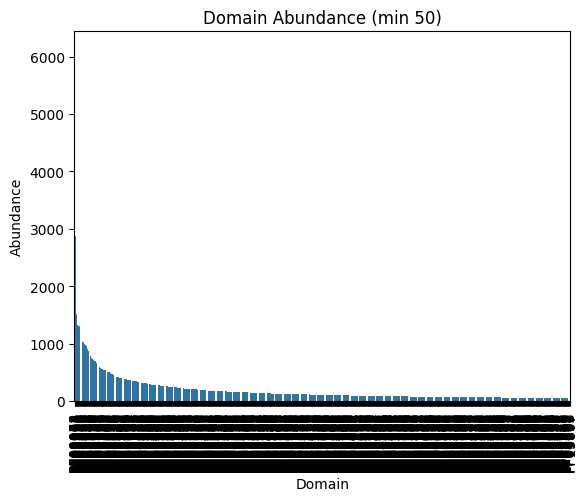

In [60]:
plot_domain_abundance(features, abundance_min=50)

In [251]:
filtered_domains = filter_domain(features, abundance_min=100)
len(filtered_domains), filtered_domains.index[:5]

(555,
 Index(['PF00078', 'PF00005', 'PF00072', 'PF02518', 'PF00501'], dtype='object', name='domain'))

In [252]:
# url = "https://www.ebi.ac.uk/interpro/api/entry/pfam/PF00550"

pfam_dict = {}
discarded = {}  # not possible to get complete data from the API
for pfam_id in filtered_domains.index:
    url = construct_pfam_url(pfam_id)
    print(f"Fetching data for PFAM ID: {pfam_id}")
    req = request.Request(url)
    try:
        res = request.urlopen(req)
    except request.HTTPError as e:
        print(f"HTTP error: {e.code} - {e.reason}")
        if e.code == 404:
            print('Not found, skipping')
            discarded[pfam_id] = None
        elif e.code == 410:
            print('Discarded, Gone from the database, ie obsolete')
        else:
            print('Unknown error, skipping')
            discarded[pfam_id] = None
        continue
    if res.status == 408:
        print('sleeping so skip request')

    payload = json.loads(res.read().decode())
    metadata = extract_from_pfam_query(payload)
    print(metadata)

    if metadata['description'] is None:  # some pfams do not have description
        print('No description, trying to fetch one from the IPR')
        ipr_id = payload['metadata']['integrated']
        print(ipr_id)
        if ipr_id is None:
            print('No IPR ID, skipping')
            discarded[pfam_id] = metadata
            continue
        url = f"https://www.ebi.ac.uk/interpro/api/entry/interpro/{ipr_id}"
        print(f"Fetching data for IPR ID: {ipr_id}")

        # API call
        req = request.Request(url)
        res = request.urlopen(req)
        if res.status == 408:
            print('sleeping so skip request')

        payload = json.loads(res.read().decode())
        metadata['description'] = payload['metadata']['description']
    
    pfam_dict[pfam_id] = metadata

    sleep(0.5)

Fetching data for PFAM ID: PF00078
{'accession': 'PF00078', 'name': {'name': 'Reverse transcriptase (RNA-dependent DNA polymerase)', 'short': 'RVT_1'}, 'description': [{'text': '<p>A reverse transcriptase gene is usually indicative of a mobile element such as a retrotransposon or retrovirus. Reverse transcriptases occur in a variety of mobile elements, including retrotransposons, retroviruses, group II introns, bacterial msDNAs, hepadnaviruses, and caulimoviruses.</p>', 'llm': False, 'checked': False, 'updated': False}]}
Fetching data for PFAM ID: PF00005
{'accession': 'PF00005', 'name': {'name': 'ABC transporter', 'short': 'ABC_tran'}, 'description': [{'text': '<p>ABC transporters for a large family of proteins responsible for translocation of a variety of compounds across biological membranes.  ABC transporters are the largest family of proteins in many completely sequenced bacteria. ABC transporters are composed of two copies of this domain and two copies of a transmembrane domain [

In [253]:
# save the pfam_dict to a file
import pickle
with open('pfam_dict_abundance_cutoff_100.pkl', 'wb') as f:
    pickle.dump(pfam_dict, f)
# load the pfam_dict from a file

del pfam_dict
# load the pfam_dict from a file
with open('pfam_dict_abundance_cutoff_100.pkl', 'rb') as f:
    pfam_dict = pickle.load(f)

In [254]:
len(pfam_dict), len(discarded)

(532, 22)

In [322]:
# clustering
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from collections import defaultdict
from time import time

from sklearn import metrics

evaluations = []
evaluations_std = []
extra_stop_words = [
    'domain', 'pfam', 'protein', 'family', 'superfamily', 'clan', 'interpro',
    'et', 'al', 'cite', '[[', ']]', '(', ')', 'figure', 'fig', 'table', 'tab', 'see',
    'also', 'example', 'examples', 'exampled', 'exampled', 'exemplary', 'exemplaryd',
    'https', 'www', 'doi', 'review', 'swissprot', 'uniprot', 'org', 'ncbi', 'pubmed', 'pubmedcentral',
    'ncbi', 'genbank', 'refseq', 'genome', 'genomic', 'gene', 'genes', 'protein', 'proteins',
    'sequence', 'sequences', 'seq', 'seqs', 'nucleotide', 'nucleotides', 'amino', 'acids',
    'acid', 'acids', 'aa', 'aa', 'nt', 'nts', 'ntseq', 'ntseqs', 'ntseqd', 'ntseqd',
]

stop_words = list(text.ENGLISH_STOP_WORDS.union(extra_stop_words))


def cluster_domains(pfam_dict, n_clusters=5, stop_words='english'):
    """
    Cluster the domains using KMeans clustering.
    """
    # Extract the domain descriptions
    descriptions = [v['description'][0]['text'] for v in pfam_dict.values()]
    # strip <p> tags
    descriptions = [desc.replace('<p>', '').replace('</p>', '') for desc in descriptions]

    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        stop_words=stop_words,
        max_df=0.15,
    )
    X = vectorizer.fit_transform(descriptions)

    # Perform KMeans clustering
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=4, random_state=42)
    kmeans.fit(X)

    # Get the cluster labels
    labels = kmeans.labels_

    # Create a dictionary to store the clusters
    clusters = {}
    for i, label in enumerate(labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(list(pfam_dict.keys())[i])

    return clusters, labels, X, kmeans, vectorizer


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [331]:
n_clusters = 30
similarity, labels, X_tfidf, kmeans, vectorizer = cluster_domains(
    pfam_dict,
    n_clusters=n_clusters,
    stop_words=stop_words
)
fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

clustering done in 0.13 ± 0.01 s 
Homogeneity: 0.526 ± 0.024
Completeness: 0.538 ± 0.019
V-measure: 0.532 ± 0.022
Adjusted Rand-Index: 0.210 ± 0.032
Silhouette Coefficient: 0.046 ± 0.002


In [332]:
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
print(f"Number of elements assigned to each cluster: {cluster_sizes}")

Number of elements assigned to each cluster: [ 5 24 16 14 18 21 21 10 42 10 12 10 30  7 15 10 23 28 13 17 28  7 39  8
 12 35 11 30  5 11]


In [333]:
X_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 14389 stored elements and shape (532, 4948)>

In [334]:
X_embedded = TSNE(
    n_components=2,
    learning_rate='auto',
    init='random',
    perplexity=30,
).fit_transform(X_tfidf.toarray())

X_embedded.shape

(532, 2)

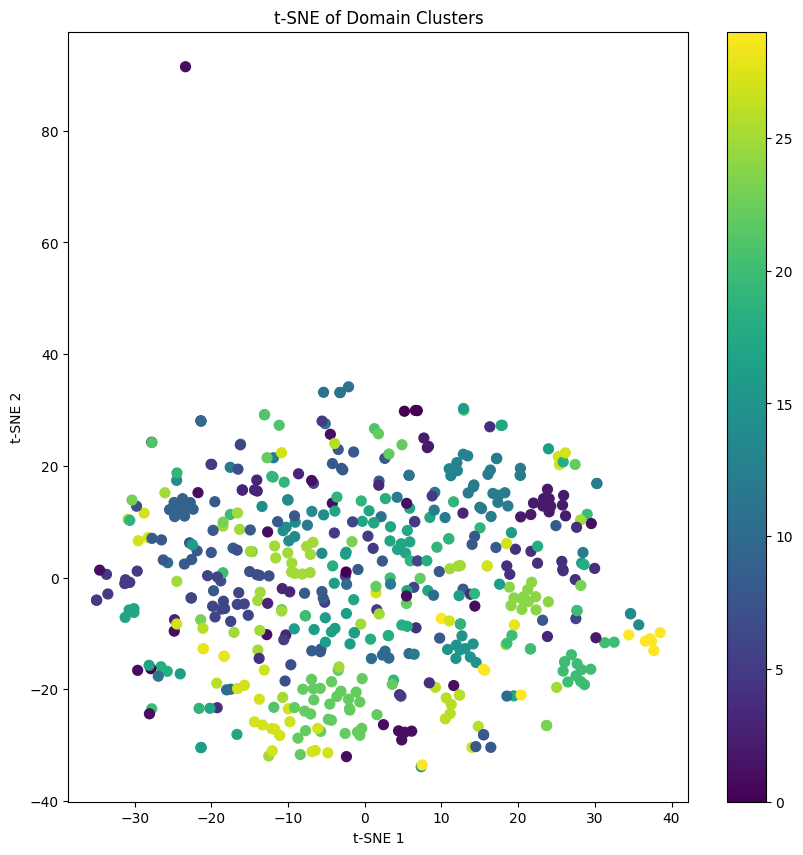

In [335]:
# plot embedding
plt.figure(figsize=(10, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
plt.title("t-SNE of Domain Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar()
plt.show()


## Latent Semantic Analysis (LSA)

In [336]:
from time import time
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.593 s
Explained variance of the SVD step: 45.4%


In [337]:
kmeans = KMeans(
    n_clusters=n_clusters,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.05 ± 0.02 s 
Homogeneity: 0.516 ± 0.006
Completeness: 0.514 ± 0.008
V-measure: 0.515 ± 0.007
Adjusted Rand-Index: 0.194 ± 0.009
Silhouette Coefficient: 0.108 ± 0.002


In [338]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(kmeans.n_clusters):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :20]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: alanine transfers murc murd mure murf peptidoglycan acetylmuramic li pentapeptide folylpolyglutamate alanyl diaminopimelic glutamate udp barrel ec ligase racemase cyanophycin 
Cluster 1: barrel periplasmic fad number class beta biosynthesis phosphate bind shown variety cofactor large activity required fold sugar ii substrate marr 
Cluster 2: membrane transmembrane outer integral channels component ion inner proton transport assembly channel helices complex dependent forms na transporters acrb permeases 
Cluster 3: dna integrase zinc catalytic ends stranded phage viral single rnase reverse host chromosome retroviral containing series carboxy linked copy covalently 
Cluster 4: ec beta alpha 99 dehydrogenase synthase oxidase hydrolase barrel phosphate related air subunit terminus specificity kinase adenine phosphoribosyl nitrilase hydrolases 
Cluster 5: dehydrogenase catalyses enzyme nad dehydrogenases oxidation dependent fad step oxidase group ec catalyse reactions biosynthesi

## APP setup

In [ ]:
pn.extension("tabulator", "mathjax")

def app():
    template = pn.template.FastListTemplate(
        title="Biosynthetic Gene Cluster Analysis",
        sidebar=[image,
                md_upload, 
                pn.Row(upload_local),
                pn.layout.Divider(margin=(-20, 0, 0, 0)),
                # this is prepared for galaxy, but not implemented yet
                # md_get_galaxy, literal_galaxy_url, literal_galaxy_key,
                button_display_loaded,
                ],
        main=[pn.Column(
            # markdown_intro,
            # pn.layout.Divider(margin=(-20, 0, 0, 0)),
            tabs,
            scroll=True,
        )],
        main_layout=None,
        accent=ACCENT,
    )
    return template

template = app()


if 'google.colab' in str(get_ipython()):  
    s = serve_app(template, env=env, name="GECCO_analyser")
else:
    template.servable()

### Uncomment this if running if running ngrok tunnel which you want to quit

In [ ]:
# only use for the ngrok tunnel in GColab
# close_server(s, env=env)